In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling2D, Flatten, Dense, Input, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

## Purpose:

Takes a timezones tweets

Model Predicts state in either subregion or overall region

In [2]:
dfa = pd.read_csv('All_US_Time_tweets.csv')

In [3]:
#df = pd.read_csv('west_time_tweets.csv')
#df = pd.read_csv('central_time_tweets.csv')
#df = pd.read_csv('east_time_tweets.csv')
df = pd.read_csv('mountain_time_tweets.csv')

df.head()

,Timestamp,TweetText,Closest_State,Closest_City,Region,Timezone,Subtime
0,18385,should i be scared that just removed his belt,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
1,28869,im craving a churro loco so bad right now,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
2,66101,time to pretend mgmt,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
3,74135,i hope i become a ghost the deadly syndrome,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
4,61538,conan is going to have a live show on april 30...,Arizona,Avenue B & C,Southwest,Mountain,South Mountain


In [4]:
df.shape

(5966, 7)

In [5]:
print(df['Closest_State'].unique())
#print(df['Subtime'].unique())

['Arizona' 'Colorado' 'Idaho' 'Montana' 'New Mexico' 'Utah' 'Wyoming']


In [6]:
df['TweetText'] = df['TweetText'].astype(str)
dfa['TweetText'] = dfa['TweetText'].astype(str)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfa['TweetText'].tolist())

In [8]:
df2 = df.copy()

In [9]:
cols = ['Closest_City','Region']
df2 = df2.drop(cols, axis = 1)

In [10]:
one_hot = pd.get_dummies(df2['Closest_State'])
df2 = df2.join(one_hot)
df2 = df2.drop('Closest_State', axis = 1)

In [11]:
df2

,Timestamp,TweetText,Timezone,Subtime,Arizona,Colorado,Idaho,Montana,New Mexico,Utah,Wyoming
0,18385,should i be scared that just removed his belt,Mountain,South Mountain,1,0,0,0,0,0,0
1,28869,im craving a churro loco so bad right now,Mountain,South Mountain,1,0,0,0,0,0,0
2,66101,time to pretend mgmt,Mountain,South Mountain,1,0,0,0,0,0,0
3,74135,i hope i become a ghost the deadly syndrome,Mountain,South Mountain,1,0,0,0,0,0,0
4,61538,conan is going to have a live show on april 30...,Mountain,South Mountain,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5961,13789,lmao i can dig that fam imma def cop 09 tho lol,Mountain,North Mountain,0,0,0,0,0,0,1
5962,69985,ummmm ron artest wtfuck,Mountain,North Mountain,0,0,0,0,0,0,1
5963,79578,lol indeed gotta know how to play the game li...,Mountain,North Mountain,0,0,0,0,0,0,1
5964,79690,lmao my nerfherder u absolutely correct,Mountain,North Mountain,0,0,0,0,0,0,1


In [12]:
x_dat = df2[['TweetText','Timestamp']]
y_dat = df2[df['Closest_State'].unique()]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_dat, y_dat, test_size = 0.25, random_state = 40)

In [14]:
x_dat["TweetText"].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.99])

count    5966.000000
mean       12.179350
std         7.086652
min         1.000000
1%          2.000000
50%        11.000000
99%        29.000000
max        36.000000
Name: TweetText, dtype: float64

In [15]:
tmax_length = 29

In [16]:
train_sequences = tokenizer.texts_to_sequences(x_train['TweetText'].tolist())
test_sequences = tokenizer.texts_to_sequences(x_test['TweetText'].tolist())

train_seq = pad_sequences(train_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')
test_seq = pad_sequences(test_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')

In [17]:
vocab_size = len(tokenizer.index_word) + 1
embedding_dim = 150

In [18]:
timestamps_train = x_train['Timestamp']
timestamps_test = x_test['Timestamp']

In [19]:
input_seq = Input(shape = (tmax_length,), name = 'Input Sequence')
input_time = Input(shape = (1,), name = "Input Timestamp")

embed = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = tmax_length)(input_seq)
convol = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(embed)
maxpool = GlobalAveragePooling1D()(convol)

concat = Concatenate()([maxpool, input_time])
dense1 = Dense(50, activation = 'relu')(concat)
dense2 = Dense(25, activation = 'relu')(dense1)
dense3 = Dense(15, activation = 'relu')(dense2)
output = Dense(len(df['Closest_State'].unique()), activation = 'sigmoid')(dense3)

model = Model(inputs = [input_seq, input_time], outputs = output)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['f1_score'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input Sequence (InputLayer)     [(None, 29)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 29, 150)      27806850    Input Sequence[0][0]             
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 27, 128)      57728       embedding[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           conv1d[0][0]                     
______________________________________________________________________________________________

In [21]:
history = model.fit([train_seq, timestamps_train], y_train, epochs = 6, batch_size = 50, validation_data = ([test_seq, timestamps_test], y_test))

Epoch 1/6
90/90 [==============================] - 23s 252ms/step - loss: 4.8456 - accuracy: 0.6086 - val_loss: 1.8659 - val_accuracy: 0.6836
Epoch 2/6
90/90 [==============================] - 22s 241ms/step - loss: 1.8261 - accuracy: 0.6965 - val_loss: 1.7899 - val_accuracy: 0.6836
Epoch 3/6
90/90 [==============================] - 22s 240ms/step - loss: 1.7494 - accuracy: 0.6965 - val_loss: 1.7156 - val_accuracy: 0.6836
Epoch 4/6
90/90 [==============================] - 22s 239ms/step - loss: 1.6761 - accuracy: 0.6965 - val_loss: 1.6457 - val_accuracy: 0.6836
Epoch 5/6
90/90 [==============================] - 22s 245ms/step - loss: 1.6070 - accuracy: 0.6965 - val_loss: 1.5806 - val_accuracy: 0.6836
Epoch 6/6
90/90 [==============================] - 22s 242ms/step - loss: 1.5426 - accuracy: 0.6965 - val_loss: 1.5201 - val_accuracy: 0.6836


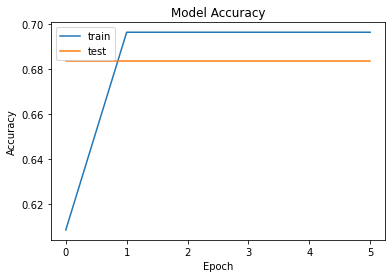

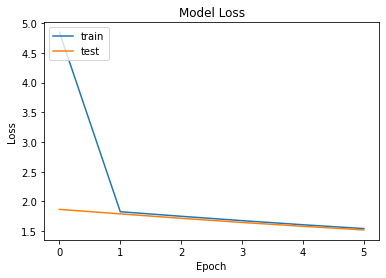

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()